### Introduction

Chapter VII -> Project Haberman Breast Cancer Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set()

### Data exploration

In [2]:
path = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv"
df = pd.read_csv(path, names = ['age','year','nodes','class'])

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,306.0,52.457516,10.803452,30.0,44.0,52.0,60.75,83.0
year,306.0,62.852941,3.249405,58.0,60.0,63.0,65.75,69.0
nodes,306.0,4.026144,7.189654,0.0,0.0,1.0,4.00,52.0
class,306.0,1.264706,0.441899,1.0,1.0,1.0,2.00,2.0


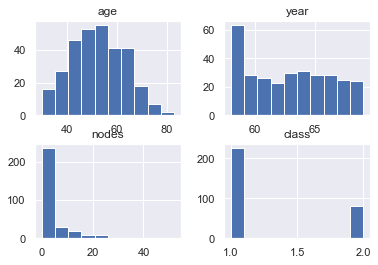

In [4]:
df.hist();

In [5]:
counter = df['class'].value_counts
pd.concat([
    counter() , counter(normalize=True) * 100
], axis=1, keys = ['class_count', 'class_pct']
)

,class_count,class_pct
1,225,73.529412
2,81,26.470588


### Baseline


Metric needed
Given that we are interested in predicting a probability of survival, we need a performancemetric that evaluates the skill of a model based on the predicted probabilities.  In this case,we  will  use  the  Brier  score  that  calculates  the  mean  squared  error  between  the  predictedprobabilities and the expected probabilities .
This can be calculated using the brier scoreloss() scikit-learn function.

A reference prediction for a problem in which we are predicting probabilities is the probability of the positive class label in the dataset.  In this case,  the positive classlabel represents non-survival and occurs about 26% in the dataset.  Therefore, predicting about 0.26471 represents the worst-case or baseline performance for a predictive model on this dataset.

Any model that has a Brier score better than this has some skill, where as any model thatas a Brier score lower than this has no skill.  The Brier Skill Score captures this importantrelationship.  We can calculate the Brier score for this default prediction strategy automaticallyfor each training set in thek-fold cross-validation process, then use it as a point of comparisonfor a given model.

In [7]:
from sklearn.metrics import brier_score_loss
y_true = (df['class'].values == 2).astype(int)
ref_probs = [y_true.mean() for _ in range(y_true.shape[0])]
bs_ref = brier_score_loss(y_true, ref_probs)

In [8]:
# calculate reference brier score

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

def load_dataset(path):
    data = pd.read_csv(path, names = ['age','year','nodes','class']).values
    X, y = data[:, :-1], data[: ,-1]
    y = LabelEncoder().fit_transform(y)
    return X, y 


# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):
	# calculate reference brier score
	ref_probs = [0.26471 for _ in range(len(y_true))]
	bs_ref = brier_score_loss(y_true=y_true,y_prob= ref_probs)
	# calculate model brier score
	bs_model = brier_score_loss(y_true= y_true, y_prob=y_prob)
	# calculate skill score
	return 1.0 - (bs_model / bs_ref)



def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(score_func=brier_skill_score, needs_proba=True)
    scores = cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation metric
	metric = make_scorer(brier_skill_score, needs_proba=True)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

In [9]:
X, y = load_dataset(path)
print(X.shape, y.shape, Counter(y))
model = DummyClassifier(strategy='prior')
scores = evaluate_model(X, y, model)
print(f"Mean BSS for baseline {np.mean(scores):.3f} and STD {np.std(scores):.3f}")

(306, 3) (306,) Counter({0: 225, 1: 81})
Mean BSS for baseline -0.000 and STD 0.000


#### Evaluate Probabilistic Models

We will evaluate a suite of models that are known to be effective at predicting probabilities. Specifically, these are models that are fit under a probabilistic framework and explicitly predict acalibrated probability for each example.  A such, this makes them well-suited to this dataset, evenwith the class imbalance.  We will evaluate the following six probabilistic models implementedwith the scikit-learn library.

We are interested in directly comparing the results from each of these algorithms.  We willcompare each algorithm based on the mean score, as well as based on their distribution of scores

In [10]:
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier


def get_models():
    models = {}
    models['LR'] = LogisticRegression(solver='lbfgs')
    models['LDA'] = LinearDiscriminantAnalysis()
    models['QDA'] = QuadraticDiscriminantAnalysis()
    models['GNB'] = GaussianNB()
    models['MNB'] = MultinomialNB()
    models['GPC'] = GaussianProcessClassifier()
    return models

In [11]:
X, y = load_dataset(path=path)

models = get_models()
results = {}
for name, model  in models.items():
    scores = evaluate_model(X, y, model)
    results[name] = scores
    print(f"{name}-> {np.mean(scores):.3f}, ({np.std(scores):.3f})")

LR-> 0.060, (0.143)
LDA-> 0.064, (0.154)
QDA-> 0.027, (0.221)
GNB-> 0.012, (0.212)
MNB-> -0.211, (0.369)
GPC-> -0.142, (0.041)


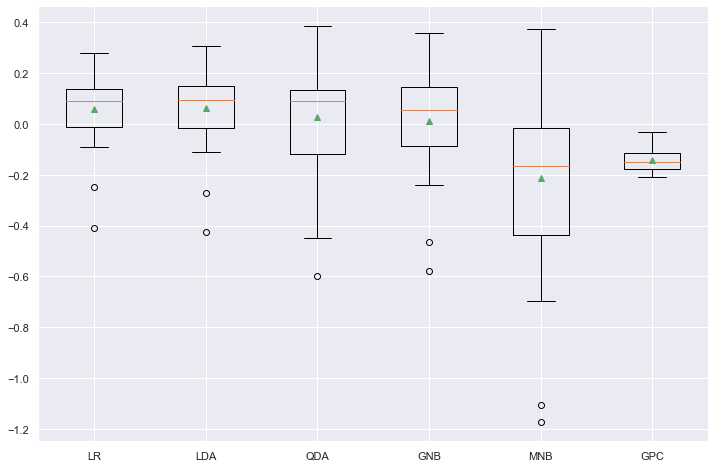

In [12]:
pyplot.figure(figsize=(12,8))
pyplot.boxplot(results.values(), 
               labels= results.keys(), showmeans=True);

####  Model Evaluation With Scaled Inputs

Algorithms like the LR and LDA are sensitive to thedistribution of the data and assume a Gaussian distribution for the input variables, which wedon’t have in all cases.Nevertheless, we can test the algorithms with standardization, where each variable is shiftedto a zero mean and unit standard deviation.  We will drop the MNB algorithm as it does notsupport negative input values.  We can achieve this by wrapping each model in aPipelinewhere the first step is aStandardScaler, which will correctly be fit on the training dataset andapplied to the test dataset within eachk-fold cross-validation evaluation, preventing any dataleakage.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
results = {}
for name, model  in models.items():
    if name == 'MNB':
        continue # dropped
    pipeline = Pipeline(steps=[('t', StandardScaler()), (name, model)])
    scores = evaluate_model(X, y, pipeline)
    results[name] = scores
    print(f"{name}-> {np.mean(scores):.3f}, ({np.std(scores):.3f})")

LR-> 0.062, (0.140)
LDA-> 0.064, (0.154)
QDA-> 0.027, (0.221)
GNB-> 0.012, (0.212)
GPC-> 0.097, (0.133)


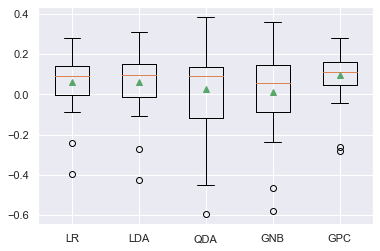

In [14]:
pyplot.boxplot(x = results.values(), 
               labels=results.keys(), showmeans=True);

#### Model Evaluation with Power Transform

There is further data preparation to make the input variables more Gaussian, such as powertransforms.
Power transforms, such as the Box-Cox and Yeo-Johnson transforms, are designed to changethe distribution to be more Gaussian.  This will help with theageinput variable in our dataset
26.5. Evaluate Probabilistic Models336and may help with thenodesvariable and un-bunch the distribution slightly.  We can use thePowerTransformerscikit-learn class to perform the Yeo-Johnson transform and automaticallydetermine the best parameters to apply based on the dataset, e.g.  how to best make eachvariable more Gaussian.  Importantly, this transformer will also standardize the dataset as partof the transform, ensuring we keep the gains seen in the previous sec

In [20]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler


def get_models():
    models = {}
    models['LR'] = LogisticRegression(solver='lbfgs')
    models['LDA'] = LinearDiscriminantAnalysis()
    models['GPC'] = GaussianProcessClassifier()
    return models

results = {}
for name, model in get_models().items():
    steps = [
        ('t1', MinMaxScaler()),
        ('t2', PowerTransformer()),
        (name, model)
    ]
    pipeline = Pipeline(steps=steps)
    scores = evaluate_model(X, y, pipeline)
    results[name] = scores
    print(f"{name}-> {np.mean(scores):.3f} +/- ({np.std(scores):.3f})")

LR-> 0.110 +/- (0.142)
LDA-> 0.107 +/- (0.164)
GPC-> 0.100 +/- (0.130)


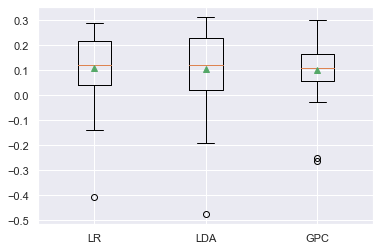

In [21]:
pyplot.boxplot(x = results.values(), 
               labels=results.keys(), showmeans=True);

#### Make a prediction on new data

We will select the Logistic Regression model with a power transform on the input data as ourfinal model.  We can define and fit this model on the entire training dataset.

In [24]:
steps = [
        ('t1', MinMaxScaler()),
        ('t2', PowerTransformer()),
        ('LR', LogisticRegression(solver='lbfgs'))
    ]
model = Pipeline(steps= steps)
model.fit(X, y)

Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),
                ('LR', LogisticRegression())])

we can use it to make predictions for new data by calling thepredictproba()function.  This will return two probabilities for each prediction, the first for survival and thesecond for non-survival, e.g.  its complement.  For example:

In [56]:
row = [31, 59, 2]
yhat = model.predict_proba([row])
yhat[0,0] * 100

83.59683513677221

In [109]:
data_rows = {}
data_rows['ns_rows'] = df[df['class'] == 2].sample(10).values[:,:-1]
data_rows['s_rows'] = df[df['class'] == 1].sample(10).values[:,:-1]

from collections import defaultdict

results = defaultdict(list)
for k, rows in data_rows.items():
    for r in rows:
        yhat = model.predict_proba([r]) # make prediction
        p_survive = yhat[0,0] * 100
        results[k].append(p_survive)
        #print(f'{k}-> {r} ::: {p_survive:.3f}')
    print(f"{k} ::mean results {np.mean(results[k]):.2f} +/- ({np.std(results[k]):.2f})")

ns_rows ::mean results 62.41 +/- (17.02)
s_rows ::mean results 72.33 +/- (14.85)
